In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

/home/lukas/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


In [32]:
data_dir = "./data/training"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [33]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [34]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [35]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [36]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [37]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [38]:
str(float(ohist[-1]))

'0.78125'

Epoch 0/9
----------
train Loss: 0.6820 Acc: 0.5750
val Loss: 0.6708 Acc: 0.6063

Epoch 1/9
----------
train Loss: 0.5402 Acc: 0.7297
val Loss: 0.5129 Acc: 0.7438

Epoch 2/9
----------
train Loss: 0.4547 Acc: 0.7984
val Loss: 0.5030 Acc: 0.7688

Epoch 3/9
----------
train Loss: 0.4399 Acc: 0.8000
val Loss: 0.4777 Acc: 0.7812

Epoch 4/9
----------
train Loss: 0.3756 Acc: 0.8359
val Loss: 0.4946 Acc: 0.7875

Epoch 5/9
----------
train Loss: 0.3686 Acc: 0.8438
val Loss: 0.4983 Acc: 0.8188

Epoch 6/9
----------
train Loss: 0.3303 Acc: 0.8516
val Loss: 0.4919 Acc: 0.7938

Epoch 7/9
----------
train Loss: 0.3317 Acc: 0.8516
val Loss: 0.4883 Acc: 0.8000

Epoch 8/9
----------
train Loss: 0.3296 Acc: 0.8703
val Loss: 0.4877 Acc: 0.8000

Epoch 9/9
----------
train Loss: 0.3054 Acc: 0.8656
val Loss: 0.4672 Acc: 0.8438

Training complete in 0m 34s
Best val Acc: 0.843750


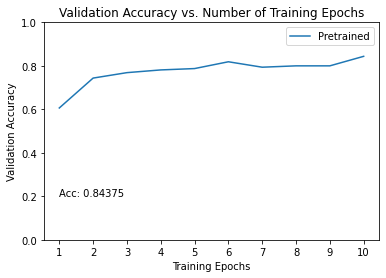

Epoch 0/19
----------
train Loss: 0.2701 Acc: 0.8906
val Loss: 0.4972 Acc: 0.8063

Epoch 1/19
----------
train Loss: 0.2557 Acc: 0.8938
val Loss: 0.4291 Acc: 0.8438

Epoch 2/19
----------
train Loss: 0.2514 Acc: 0.8875
val Loss: 0.4624 Acc: 0.7812

Epoch 3/19
----------
train Loss: 0.2402 Acc: 0.9062
val Loss: 0.4972 Acc: 0.8063

Epoch 4/19
----------
train Loss: 0.2247 Acc: 0.9156
val Loss: 0.4796 Acc: 0.8438

Epoch 5/19
----------
train Loss: 0.2355 Acc: 0.8875
val Loss: 0.5796 Acc: 0.8000

Epoch 6/19
----------
train Loss: 0.2133 Acc: 0.9234
val Loss: 0.4923 Acc: 0.8375

Epoch 7/19
----------
train Loss: 0.1949 Acc: 0.9234
val Loss: 0.5018 Acc: 0.8375

Epoch 8/19
----------
train Loss: 0.1863 Acc: 0.9219
val Loss: 0.5400 Acc: 0.8250

Epoch 9/19
----------
train Loss: 0.1752 Acc: 0.9203
val Loss: 0.5679 Acc: 0.8250

Epoch 10/19
----------
train Loss: 0.1628 Acc: 0.9281
val Loss: 0.5862 Acc: 0.8188

Epoch 11/19
----------
train Loss: 0.1548 Acc: 0.9313
val Loss: 0.5942 Acc: 0.8250

Ep

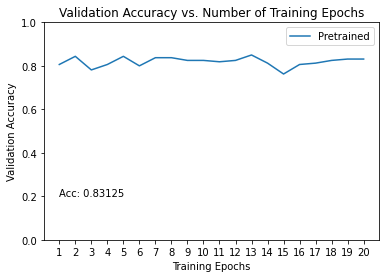

Epoch 0/29
----------
train Loss: 0.1634 Acc: 0.9297
val Loss: 0.6132 Acc: 0.7938

Epoch 1/29
----------
train Loss: 0.1426 Acc: 0.9375
val Loss: 0.6449 Acc: 0.8188

Epoch 2/29
----------
train Loss: 0.1489 Acc: 0.9453
val Loss: 0.6446 Acc: 0.8313

Epoch 3/29
----------
train Loss: 0.1339 Acc: 0.9547
val Loss: 0.6382 Acc: 0.7938

Epoch 4/29
----------
train Loss: 0.1550 Acc: 0.9266
val Loss: 0.7380 Acc: 0.8313

Epoch 5/29
----------
train Loss: 0.1318 Acc: 0.9531
val Loss: 0.6888 Acc: 0.8500

Epoch 6/29
----------
train Loss: 0.1408 Acc: 0.9375
val Loss: 0.6697 Acc: 0.8313

Epoch 7/29
----------
train Loss: 0.1543 Acc: 0.9422
val Loss: 0.6608 Acc: 0.8563

Epoch 8/29
----------
train Loss: 0.1161 Acc: 0.9531
val Loss: 0.6808 Acc: 0.8125

Epoch 9/29
----------
train Loss: 0.1476 Acc: 0.9359
val Loss: 0.7122 Acc: 0.8250

Epoch 10/29
----------
train Loss: 0.1420 Acc: 0.9484
val Loss: 0.7061 Acc: 0.8438

Epoch 11/29
----------
train Loss: 0.1075 Acc: 0.9578
val Loss: 0.7519 Acc: 0.8313

Ep

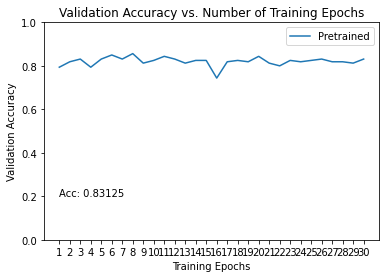

Epoch 0/39
----------
train Loss: 0.1575 Acc: 0.9328
val Loss: 0.6744 Acc: 0.8563

Epoch 1/39
----------
train Loss: 0.1355 Acc: 0.9406
val Loss: 0.7381 Acc: 0.7812

Epoch 2/39
----------
train Loss: 0.1070 Acc: 0.9578
val Loss: 0.6855 Acc: 0.8250

Epoch 3/39
----------
train Loss: 0.1382 Acc: 0.9406
val Loss: 0.8192 Acc: 0.7688

Epoch 4/39
----------
train Loss: 0.0966 Acc: 0.9563
val Loss: 0.7191 Acc: 0.8313

Epoch 5/39
----------
train Loss: 0.1571 Acc: 0.9313
val Loss: 0.7058 Acc: 0.8250

Epoch 6/39
----------
train Loss: 0.1032 Acc: 0.9641
val Loss: 0.7331 Acc: 0.8188

Epoch 7/39
----------
train Loss: 0.1062 Acc: 0.9563
val Loss: 0.7310 Acc: 0.8313

Epoch 8/39
----------
train Loss: 0.1179 Acc: 0.9500
val Loss: 0.6951 Acc: 0.8250

Epoch 9/39
----------
train Loss: 0.1253 Acc: 0.9484
val Loss: 0.6722 Acc: 0.8313

Epoch 10/39
----------
train Loss: 0.1114 Acc: 0.9547
val Loss: 0.7569 Acc: 0.8188

Epoch 11/39
----------
train Loss: 0.0878 Acc: 0.9625
val Loss: 0.8089 Acc: 0.8188

Ep

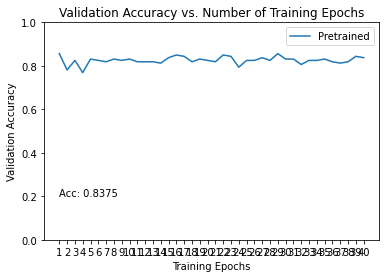

Epoch 0/49
----------
train Loss: 0.1144 Acc: 0.9563
val Loss: 0.7227 Acc: 0.8625

Epoch 1/49
----------
train Loss: 0.1189 Acc: 0.9484
val Loss: 0.7319 Acc: 0.8500

Epoch 2/49
----------
train Loss: 0.1613 Acc: 0.9469
val Loss: 0.7516 Acc: 0.8313

Epoch 3/49
----------
train Loss: 0.1401 Acc: 0.9453
val Loss: 0.7919 Acc: 0.7750

Epoch 4/49
----------
train Loss: 0.1269 Acc: 0.9500
val Loss: 0.7625 Acc: 0.8313

Epoch 5/49
----------
train Loss: 0.1010 Acc: 0.9594
val Loss: 0.8014 Acc: 0.8250

Epoch 6/49
----------
train Loss: 0.1491 Acc: 0.9359
val Loss: 0.7572 Acc: 0.8313

Epoch 7/49
----------
train Loss: 0.1061 Acc: 0.9547
val Loss: 0.8451 Acc: 0.8313

Epoch 8/49
----------
train Loss: 0.0929 Acc: 0.9641
val Loss: 0.8203 Acc: 0.8250

Epoch 9/49
----------
train Loss: 0.1277 Acc: 0.9453
val Loss: 0.8157 Acc: 0.8438

Epoch 10/49
----------
train Loss: 0.1022 Acc: 0.9672
val Loss: 0.7892 Acc: 0.8625

Epoch 11/49
----------
train Loss: 0.0973 Acc: 0.9594
val Loss: 0.7768 Acc: 0.8375

Ep

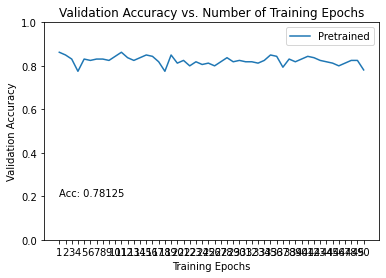

Epoch 0/59
----------
train Loss: 0.1633 Acc: 0.9250
val Loss: 0.7000 Acc: 0.8313

Epoch 1/59
----------
train Loss: 0.1252 Acc: 0.9516
val Loss: 0.7363 Acc: 0.8250

Epoch 2/59
----------
train Loss: 0.1361 Acc: 0.9453
val Loss: 0.7048 Acc: 0.8313

Epoch 3/59
----------
train Loss: 0.1343 Acc: 0.9359
val Loss: 0.7571 Acc: 0.8063

Epoch 4/59
----------
train Loss: 0.1214 Acc: 0.9391
val Loss: 0.7208 Acc: 0.8250

Epoch 5/59
----------
train Loss: 0.1531 Acc: 0.9375
val Loss: 0.6963 Acc: 0.8375

Epoch 6/59
----------
train Loss: 0.1125 Acc: 0.9563
val Loss: 0.6922 Acc: 0.8375

Epoch 7/59
----------
train Loss: 0.1432 Acc: 0.9531
val Loss: 0.6798 Acc: 0.8125

Epoch 8/59
----------
train Loss: 0.1230 Acc: 0.9484
val Loss: 0.6638 Acc: 0.8313

Epoch 9/59
----------
train Loss: 0.1242 Acc: 0.9594
val Loss: 0.6805 Acc: 0.8500

Epoch 10/59
----------
train Loss: 0.0797 Acc: 0.9719
val Loss: 0.6513 Acc: 0.8125

Epoch 11/59
----------
train Loss: 0.0887 Acc: 0.9672
val Loss: 0.7241 Acc: 0.8188

Ep

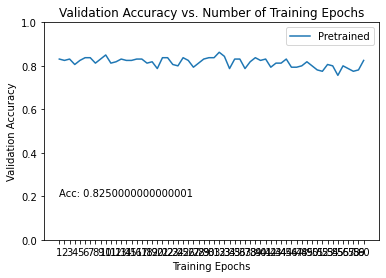

Epoch 0/69
----------
train Loss: 0.0781 Acc: 0.9594
val Loss: 0.7561 Acc: 0.8250

Epoch 1/69
----------
train Loss: 0.0660 Acc: 0.9766
val Loss: 0.7134 Acc: 0.8375

Epoch 2/69
----------
train Loss: 0.0892 Acc: 0.9641
val Loss: 0.8088 Acc: 0.8313

Epoch 3/69
----------
train Loss: 0.0855 Acc: 0.9656
val Loss: 0.7363 Acc: 0.8188

Epoch 4/69
----------
train Loss: 0.0609 Acc: 0.9797
val Loss: 0.7565 Acc: 0.8188

Epoch 5/69
----------
train Loss: 0.0631 Acc: 0.9734
val Loss: 0.8635 Acc: 0.8125

Epoch 6/69
----------
train Loss: 0.0611 Acc: 0.9750
val Loss: 0.9077 Acc: 0.8063

Epoch 7/69
----------
train Loss: 0.0979 Acc: 0.9688
val Loss: 0.8546 Acc: 0.8000

Epoch 8/69
----------
train Loss: 0.0766 Acc: 0.9609
val Loss: 0.9147 Acc: 0.8000

Epoch 9/69
----------
train Loss: 0.0788 Acc: 0.9703
val Loss: 0.8378 Acc: 0.8250

Epoch 10/69
----------
train Loss: 0.0715 Acc: 0.9719
val Loss: 0.8825 Acc: 0.7875

Epoch 11/69
----------
train Loss: 0.0754 Acc: 0.9688
val Loss: 0.9045 Acc: 0.7688

Ep

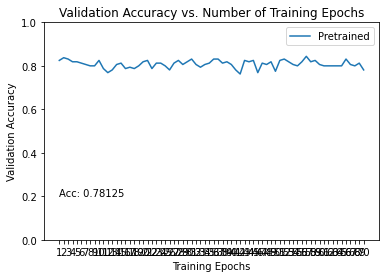

Epoch 0/79
----------
train Loss: 0.0594 Acc: 0.9781
val Loss: 0.9787 Acc: 0.8063

Epoch 1/79
----------
train Loss: 0.0623 Acc: 0.9734
val Loss: 1.0720 Acc: 0.7750

Epoch 2/79
----------
train Loss: 0.0482 Acc: 0.9844
val Loss: 1.1325 Acc: 0.8000

Epoch 3/79
----------
train Loss: 0.0497 Acc: 0.9813
val Loss: 1.1252 Acc: 0.8063

Epoch 4/79
----------
train Loss: 0.0664 Acc: 0.9766
val Loss: 0.9770 Acc: 0.8313

Epoch 5/79
----------
train Loss: 0.0455 Acc: 0.9828
val Loss: 1.0230 Acc: 0.8250

Epoch 6/79
----------
train Loss: 0.0553 Acc: 0.9781
val Loss: 1.1066 Acc: 0.8125

Epoch 7/79
----------
train Loss: 0.0606 Acc: 0.9781
val Loss: 1.0709 Acc: 0.8000

Epoch 8/79
----------
train Loss: 0.0525 Acc: 0.9813
val Loss: 1.1000 Acc: 0.8313

Epoch 9/79
----------
train Loss: 0.0366 Acc: 0.9875
val Loss: 1.1029 Acc: 0.8313

Epoch 10/79
----------
train Loss: 0.0512 Acc: 0.9844
val Loss: 1.0901 Acc: 0.8313

Epoch 11/79
----------
train Loss: 0.0718 Acc: 0.9797
val Loss: 0.9763 Acc: 0.8188

Ep

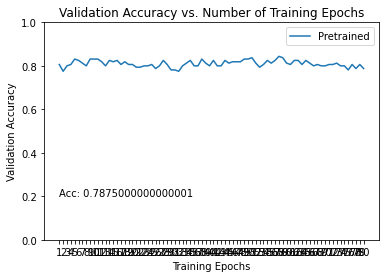

Epoch 0/89
----------
train Loss: 0.0271 Acc: 0.9891
val Loss: 1.0830 Acc: 0.8250

Epoch 1/89
----------
train Loss: 0.0317 Acc: 0.9922
val Loss: 1.0828 Acc: 0.8125

Epoch 2/89
----------
train Loss: 0.0516 Acc: 0.9813
val Loss: 1.0832 Acc: 0.8125

Epoch 3/89
----------
train Loss: 0.0580 Acc: 0.9828
val Loss: 1.1819 Acc: 0.8000

Epoch 4/89
----------
train Loss: 0.0377 Acc: 0.9828
val Loss: 1.2441 Acc: 0.8000

Epoch 5/89
----------
train Loss: 0.0559 Acc: 0.9766
val Loss: 1.1727 Acc: 0.8063

Epoch 6/89
----------
train Loss: 0.0388 Acc: 0.9875
val Loss: 1.1342 Acc: 0.8125

Epoch 7/89
----------
train Loss: 0.0581 Acc: 0.9734
val Loss: 1.1504 Acc: 0.8438

Epoch 8/89
----------
train Loss: 0.0432 Acc: 0.9750
val Loss: 1.0628 Acc: 0.8250

Epoch 9/89
----------
train Loss: 0.0340 Acc: 0.9828
val Loss: 1.1138 Acc: 0.8063

Epoch 10/89
----------
train Loss: 0.0425 Acc: 0.9813
val Loss: 1.1867 Acc: 0.8250

Epoch 11/89
----------
train Loss: 0.0335 Acc: 0.9922
val Loss: 1.1761 Acc: 0.8000

Ep

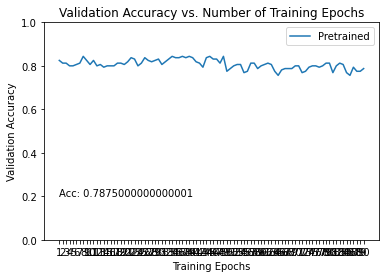

Epoch 0/99
----------
train Loss: 0.0382 Acc: 0.9859
val Loss: 1.1608 Acc: 0.8188

Epoch 1/99
----------
train Loss: 0.0489 Acc: 0.9797
val Loss: 1.1029 Acc: 0.8188

Epoch 2/99
----------
train Loss: 0.0356 Acc: 0.9844
val Loss: 1.1542 Acc: 0.8000

Epoch 3/99
----------
train Loss: 0.0370 Acc: 0.9906
val Loss: 1.2350 Acc: 0.8000

Epoch 4/99
----------
train Loss: 0.0713 Acc: 0.9828
val Loss: 1.2394 Acc: 0.8000

Epoch 5/99
----------
train Loss: 0.0372 Acc: 0.9859
val Loss: 1.1604 Acc: 0.8125

Epoch 6/99
----------
train Loss: 0.0585 Acc: 0.9781
val Loss: 1.3164 Acc: 0.8125

Epoch 7/99
----------
train Loss: 0.0525 Acc: 0.9781
val Loss: 1.1753 Acc: 0.8188

Epoch 8/99
----------
train Loss: 0.0393 Acc: 0.9844
val Loss: 1.2773 Acc: 0.8250

Epoch 9/99
----------
train Loss: 0.0384 Acc: 0.9844
val Loss: 1.2123 Acc: 0.7938

Epoch 10/99
----------
train Loss: 0.0258 Acc: 0.9922
val Loss: 1.1459 Acc: 0.8188

Epoch 11/99
----------
train Loss: 0.0356 Acc: 0.9875
val Loss: 1.1637 Acc: 0.7812

Ep

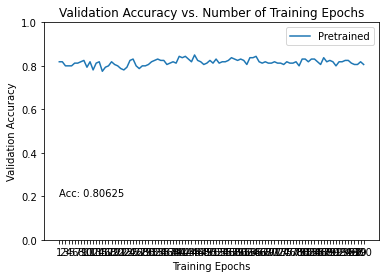

In [39]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
for i in range(0,10):
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    torch.save(model_ft, './models/' + str(num_epochs))
    
    ohist = []
    ohist = [h.cpu().numpy() for h in hist]
    plt.title("Validation Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.text(1,0.2,'Acc: ' + str(float(ohist[-1])))
    plt.legend()
    plt.savefig('./models/' + str(num_epochs) + '.png')
    plt.show()
    
    num_epochs = num_epochs + 10

Epoch 0/14
----------
train Loss: 0.7722 Acc: 0.5547
val Loss: 0.7298 Acc: 0.6313

Epoch 1/14
----------
train Loss: 0.6778 Acc: 0.6047
val Loss: 0.6070 Acc: 0.6750

Epoch 2/14
----------
train Loss: 0.6190 Acc: 0.6594
val Loss: 0.6757 Acc: 0.6562

Epoch 3/14
----------
train Loss: 0.6198 Acc: 0.6594
val Loss: 0.6298 Acc: 0.6562

Epoch 4/14
----------
train Loss: 0.6851 Acc: 0.6484
val Loss: 0.8402 Acc: 0.5813

Epoch 5/14
----------
train Loss: 0.6385 Acc: 0.6594
val Loss: 0.7100 Acc: 0.6000

Epoch 6/14
----------
train Loss: 0.6123 Acc: 0.6875
val Loss: 0.6093 Acc: 0.6875

Epoch 7/14
----------
train Loss: 0.5849 Acc: 0.7016
val Loss: 0.7165 Acc: 0.6313

Epoch 8/14
----------
train Loss: 0.5982 Acc: 0.6922
val Loss: 0.6146 Acc: 0.6938

Epoch 9/14
----------
train Loss: 0.6280 Acc: 0.6984
val Loss: 0.9496 Acc: 0.5375

Epoch 10/14
----------
train Loss: 0.5904 Acc: 0.7031
val Loss: 0.5630 Acc: 0.6938

Epoch 11/14
----------
train Loss: 0.5943 Acc: 0.6797
val Loss: 0.5719 Acc: 0.7000

Ep

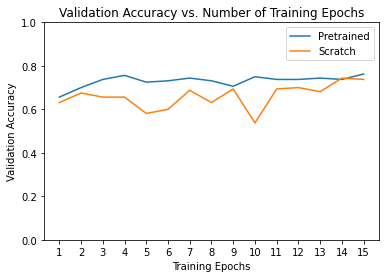

In [9]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()